# Univariate Analysis

The objective of this notebook is to analyze each variable separately to understand its distribution, central tendencies (mean, median), and dispersion (variance, standard deviation). It also includes visualization of variables.

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import pie_plot, qq_plots, skewness_and_kurtosis, detect_outliers
import numpy as np

In [13]:
data = pd.read_csv('../data/processed/df_fraud.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


In [14]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            6362620 non-null  int64  
 1   type            6362620 non-null  object 
 2   amount          6362620 non-null  float64
 3   nameOrig        6362620 non-null  object 
 4   oldbalanceOrig  6362620 non-null  float64
 5   newbalanceOrig  6362620 non-null  float64
 6   nameDest        6362620 non-null  object 
 7   oldbalanceDest  6362620 non-null  float64
 8   newbalanceDest  6362620 non-null  float64
 9   isFraud         6362620 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 485.4+ MB


# Visualization of the target variable

## isFraud

In [15]:
data['isFraud'].describe()

count    6.362620e+06
mean     1.290820e-03
std      3.590480e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: isFraud, dtype: float64

In [16]:
data['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [17]:
data['isFraud'].value_counts(normalize=True).mul(100).apply(lambda x: f'{x:.3f}%')

isFraud
0    99.871%
1     0.129%
Name: proportion, dtype: object

Observations: 

The vast majority of transactions are non-fraudulent, which is evidenced by the very low mean (0.00129082) and the percentiles (25%, 50%, 75%) all being 0. The standard deviation is also low, indicating little variability. This is typical in fraud datasets, where fraudulent instances are much less common compared to non-fraudulent instances.

# Visualization of the categorical variables

## Type

In [18]:
data['type'].describe(include = ['O'])

count      6362620
unique           5
top       CASH_OUT
freq       2237500
Name: type, dtype: object

In [19]:
data['type'].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

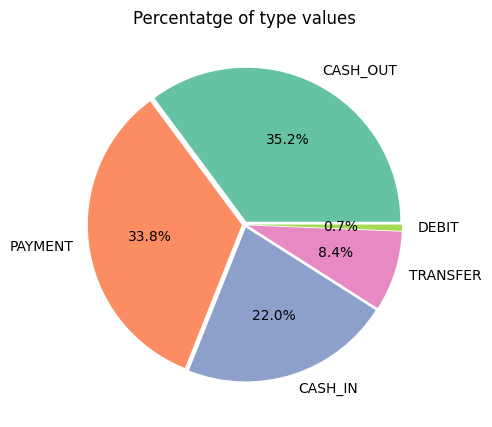

In [20]:
pie_plot(data['type'])

Observations: 
- CASH_OUT & PAYMENT are the predominant types of transactions
- CASH_IN & TRANSFER are relatively popular
- DEBIT is the less common among types of transactions. 



## nameOrig and nameDest

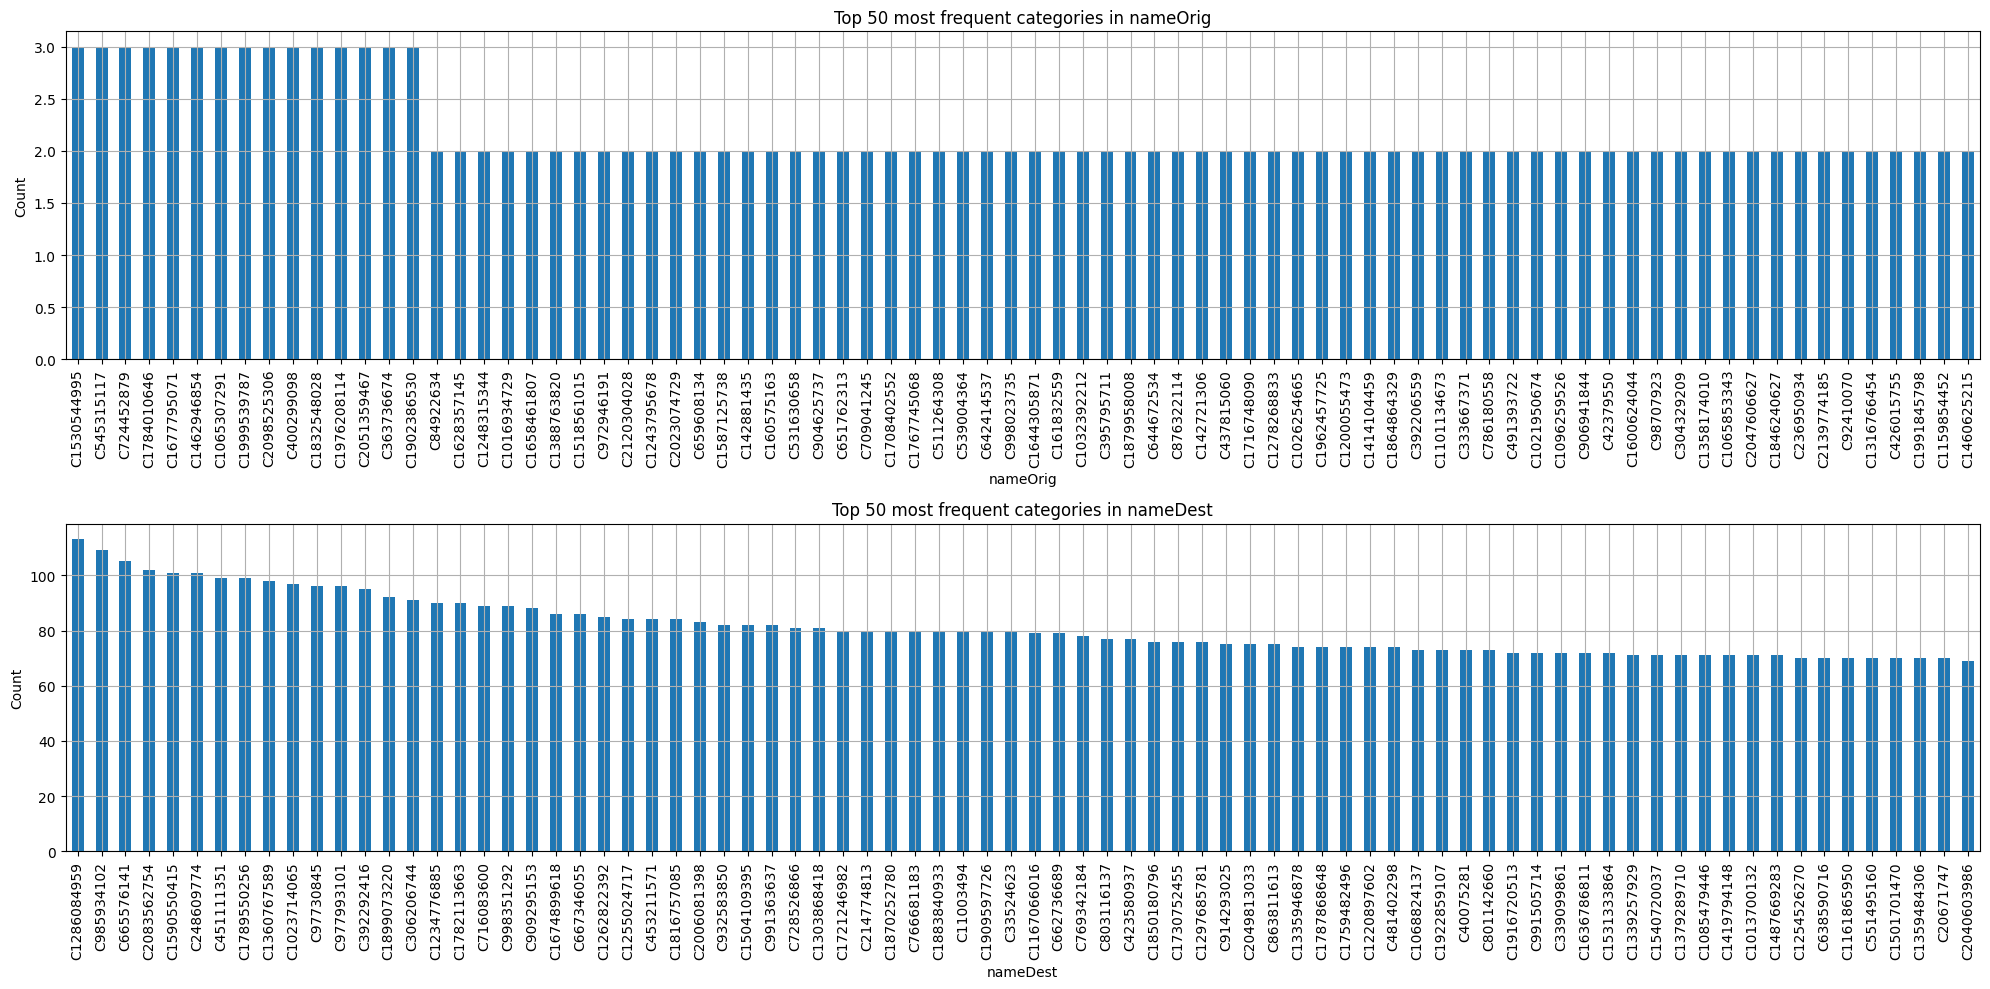

In [21]:

categorical_cols = [ 'nameOrig', 'nameDest']

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))

for ax, col in zip(axs, categorical_cols):
    top_categories = data[col].value_counts().nlargest(80)
    
    top_categories.plot(kind='bar', ax=ax)
    
    ax.set_title(f'Top 50 most frequent categories in {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.grid(True)

plt.tight_layout()
plt.show()

Observations:
- nameOrig: There are many accounts that have sent money more than 1 time. Is there a relationship between fraudulent behaviours and the amount of times the account has sent money?

- nameDest: The amount of times that the most common accounts is way higher so for. Can I cluster them somehow? It gonna be interesting to analyse if in this case the accounts with high frequency have some relationship with the fraudulent behaviours too. 

# Visualization of the numerical variables

### Basic overview of the distributions for all variables

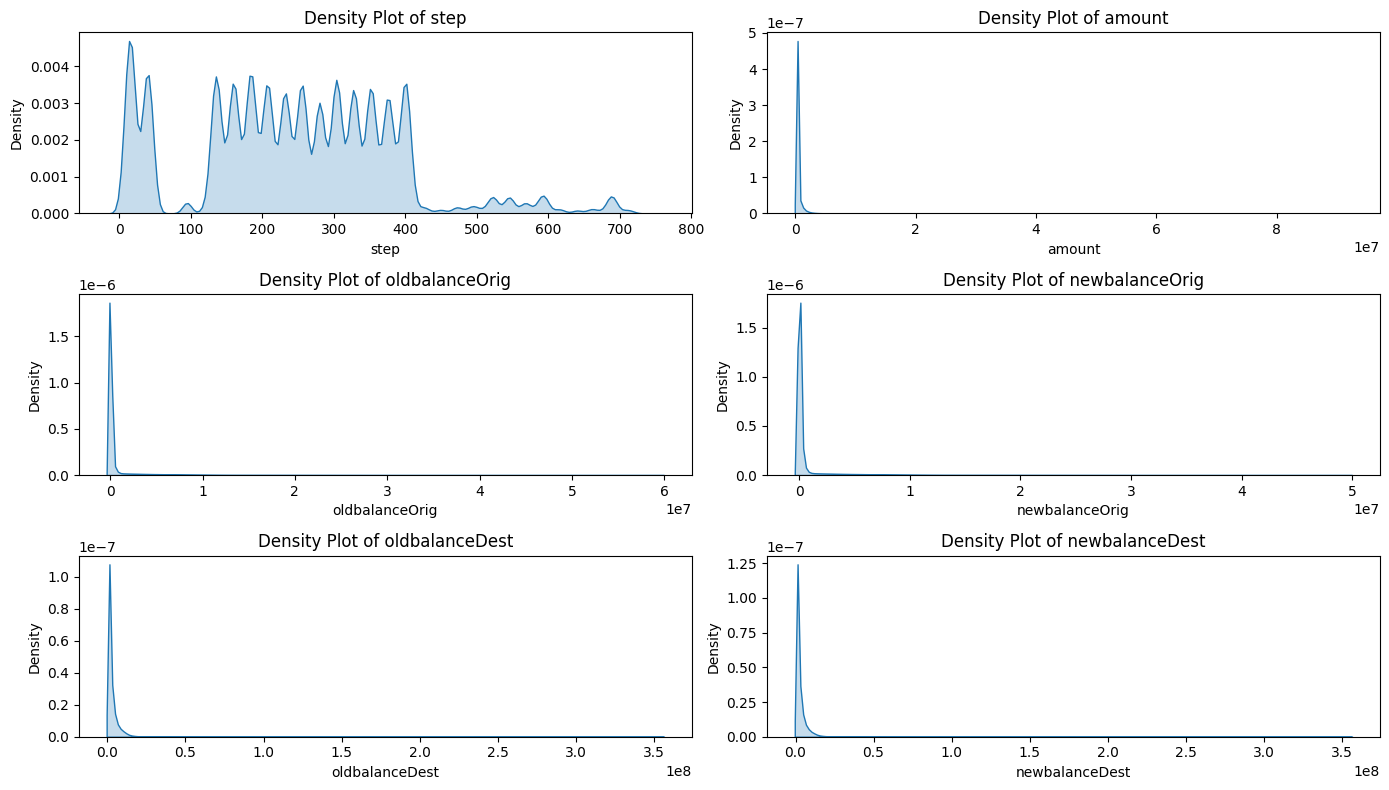

In [22]:
numeric_cols =['step', 'amount','oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest','newbalanceDest']


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,8))
axes = axes.flatten()  

for ax, col in zip(axes, numeric_cols):
    sns.kdeplot(data[col], ax=ax, fill=True)
    ax.set_title(f'Density Plot of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

Observations:

- The columns 'amount','oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest','newbalanceDest' have most of the values slighty above 0. 

- The column 'step' has  two ranges that look interesting and will be checked later more accurately.

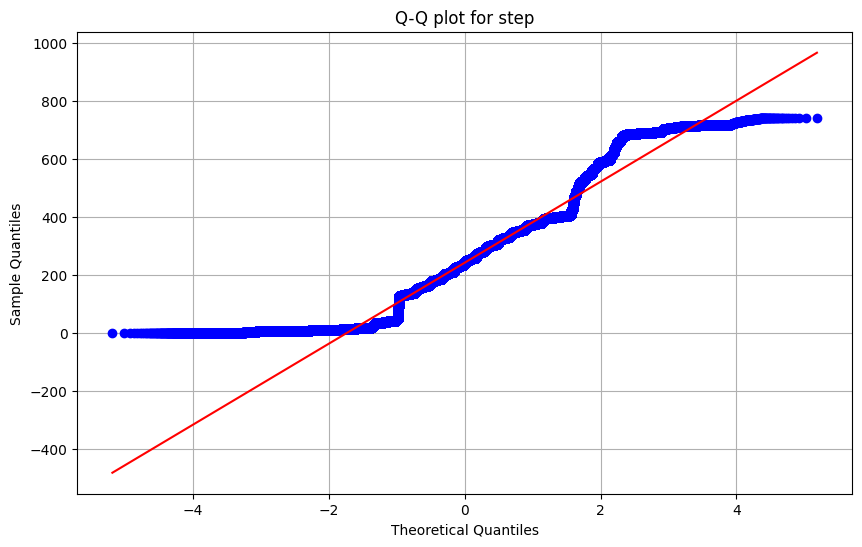

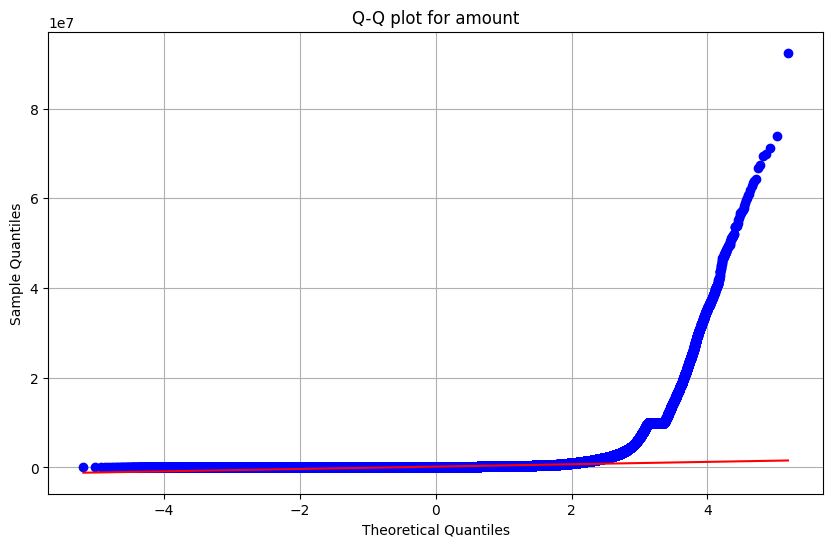

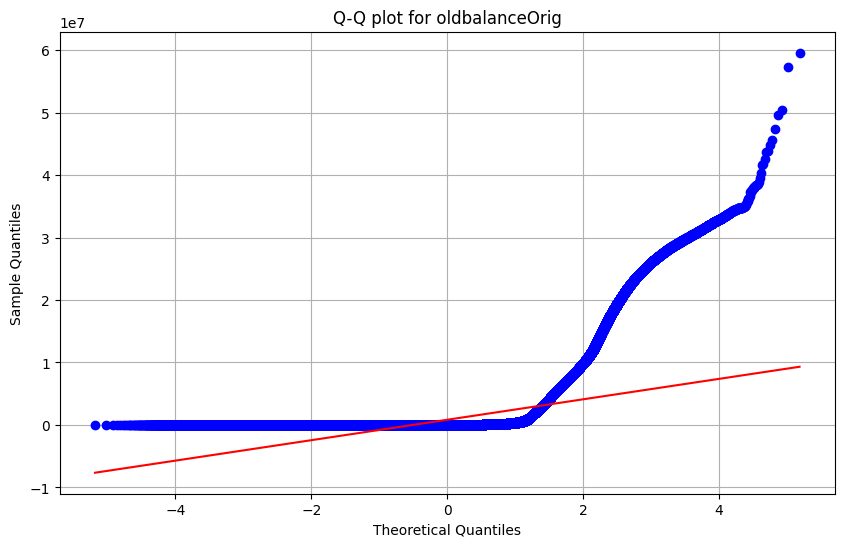

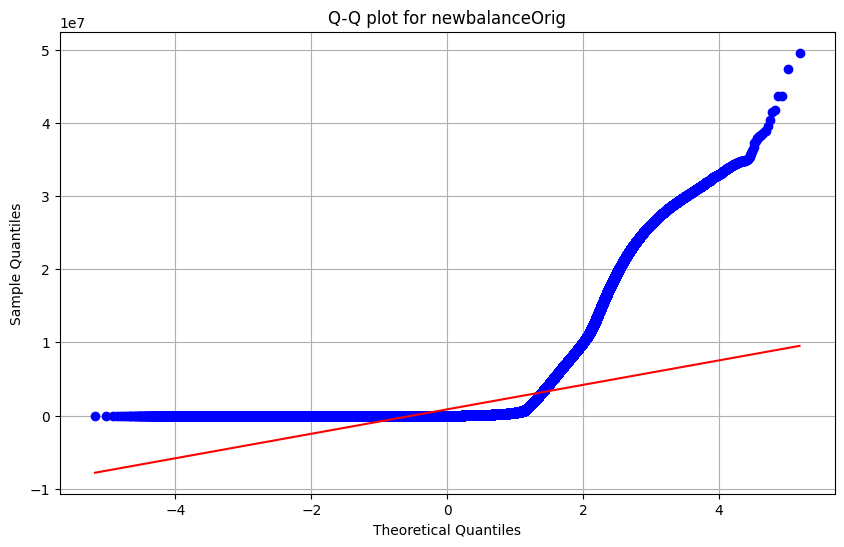

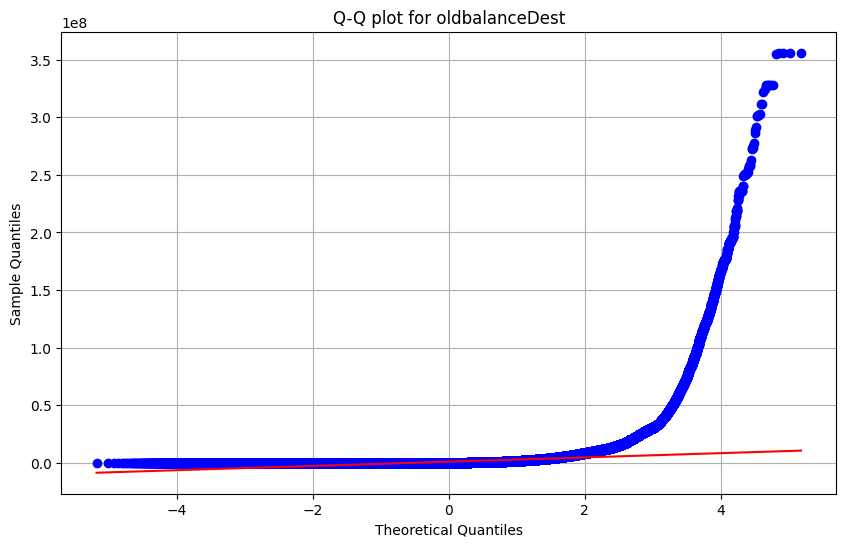

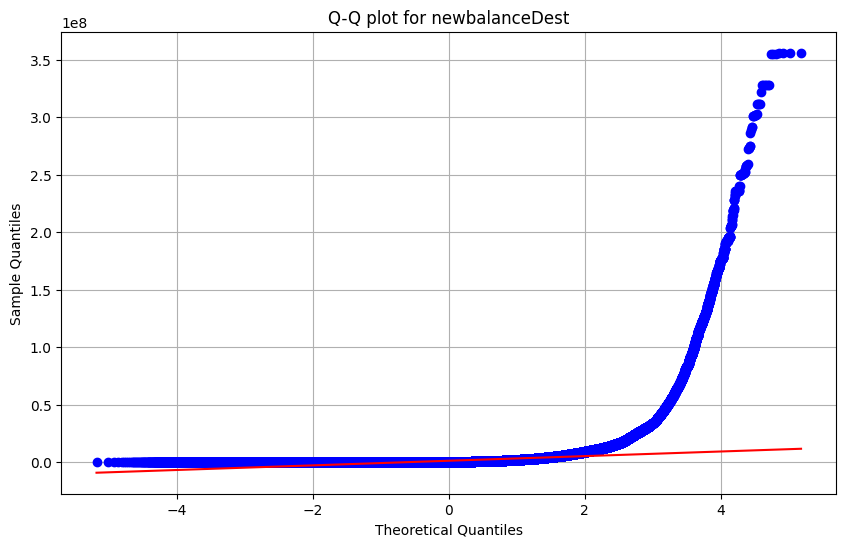

In [23]:
qq_plots(data, numeric_cols)

Observations:

- Positive skewness in every column. 

- As we said in the previous plots, step shows a bit more simetry but it remains far from being a normal distribution.

### Step

In [24]:
data['step'].describe()

count    6.362620e+06
mean     2.433972e+02
std      1.423320e+02
min      1.000000e+00
25%      1.560000e+02
50%      2.390000e+02
75%      3.350000e+02
max      7.430000e+02
Name: step, dtype: float64

Observations:
- The mean (243.40) and median (239.00) are close, indicating relatively symmetric distribution. However, the standard deviation (142.33) suggests considerable variability in the data.
- The wide range (from 1 to 743) and the large difference between the 25th percentile (156) and the 75th percentile (335) suggest that there are high values or outliers in the dataset. This indicates potential right skewness (I'll check it later), with the distribution having a longer tail on the right side.

Since I have many rows, I'm going to use a density plot for better visualization 

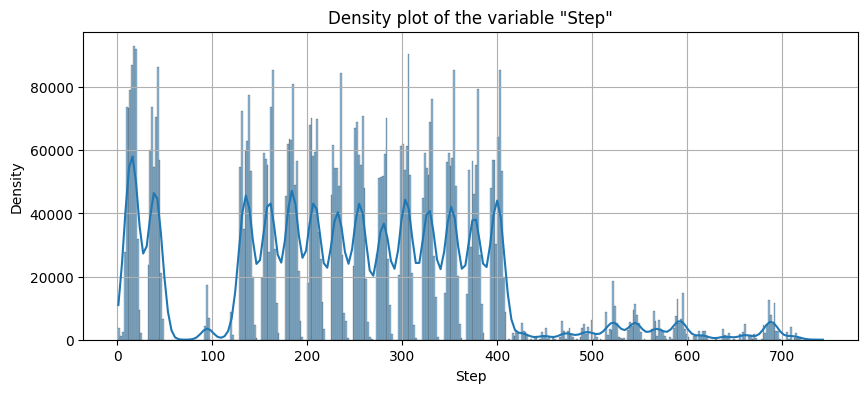

In [25]:
plt.figure(figsize=(10, 4))
sns.histplot(data['step'], kde=True)
plt.title('Density plot of the variable "Step"')
plt.xlabel('Step')
plt.ylabel('Density')
plt.grid()
plt.show()

Observations:

For context, 1 step represents 1 hour. The total range of hour data is equivalent to a month. 

The are two main step ranges where the amount of transactions are very likely to happen. 
- Are they related to fraudulent behavior? 
- How is the behavior divided per day instead?

---

I'm going to check the distribution per day

In [26]:
data['day_of_month'] = np.ceil(data['step'] / 24).astype(int)

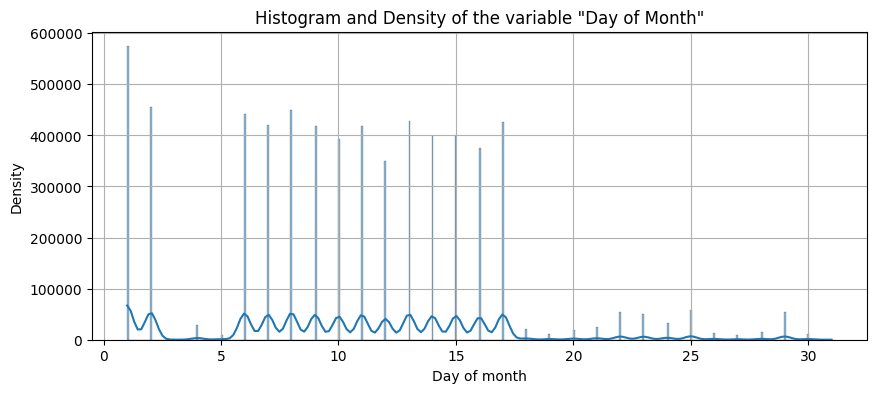

In [27]:
plt.figure(figsize=(10, 4))
sns.histplot(data['day_of_month'], kde=True)
plt.title('Histogram and Density of the variable "Day of Month"')
plt.xlabel('Day of month')
plt.ylabel('Density')
plt.grid()
plt.show()

Observations: 

The behavior is more clear with this graph. There are two main groups:

- Group 1: The ones that use the first and second day to do transactions. It makes sense since people get paid at the end of the month so they can use their money at the begining of the next month. 
- Group 2: The ones that take from 6 to 17 days to do transactions. That doesn't make sense to me. I'll try to understand this behavior later comparing it with the column isFraud and maybe other variables.. follow the path to the bivariate and multivariate analysis notebooks for more possible insights :)


In [28]:
skewness_and_kurtosis(data, 'step')

{'skewness': 0.3751768000211631, 'kurtosis': 0.3290693534211582}

Observations: 

- Skewness is very low, good, but the distribution is not normal. 
- Kurtosis is ver low (Platykurtic), light tails and flat peak so I won't find a huge amount of outliers

In [29]:
skewness_and_kurtosis(data, 'day_of_month')

{'skewness': 0.3778476502506202, 'kurtosis': 0.3323002492629832}

Observations:

The new approach based on days slightly increases both skewness and kurtosis

### Amount

In [30]:
data['amount'].describe()

count    6.362620e+06
mean     1.798619e+05
std      6.038582e+05
min      0.000000e+00
25%      1.338957e+04
50%      7.487194e+04
75%      2.087215e+05
max      9.244552e+07
Name: amount, dtype: float64

Observations:

- The mean (179,861.90) is significantly higher than the median (74,871.94), which, along with a high standard deviation (603,858.22), indicates that the distribution is heavily skewed to the right with a large number of high-value outliers.

- The minimum value is 0 and the maximum is 92,445,200, suggesting a wide range of values. The 25th percentile (13,389.57) and 75th percentile (208,721.50) show that the upper range of values contributes significantly to the high mean, further indicating right-skewness and potential outliers.

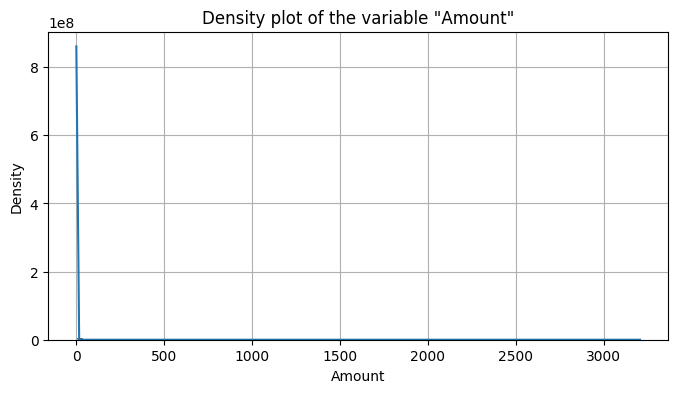

In [31]:
count = data['amount'].value_counts()

plt.figure(figsize=(8, 4))
sns.histplot(count, kde=True, bins = 100)
plt.title('Density plot of the variable "Amount"')
plt.xlabel('Amount')
plt.ylabel('Density')
plt.grid()
plt.show()

I see almost nothing here, let's zoom in the small values of amount

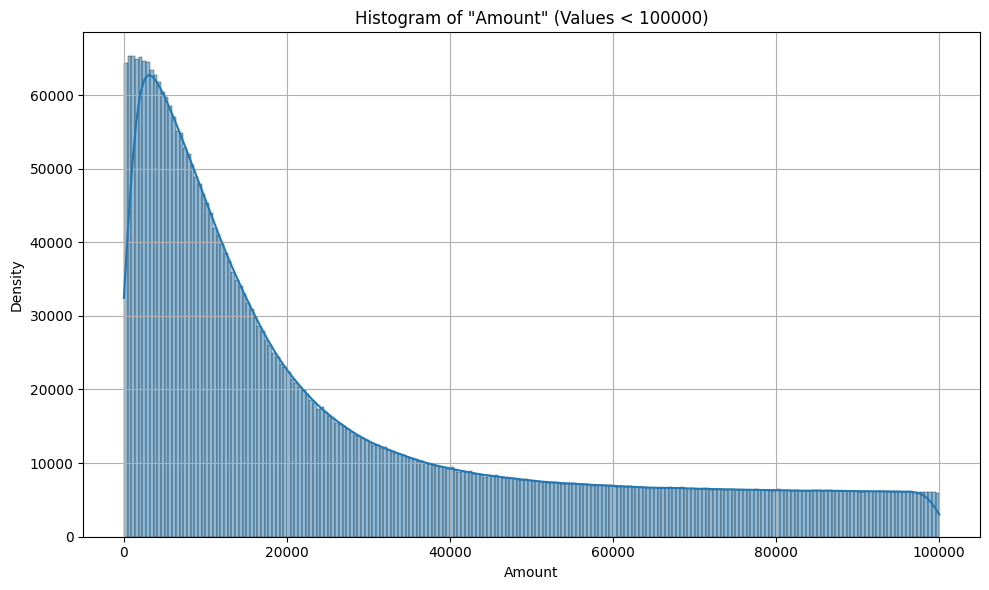

In [32]:
plt.figure(figsize=(10, 6))


sns.histplot(data[data['amount'] < 100000]['amount'], kde=True)
plt.title('Histogram of "Amount" (Values < 100000)')
plt.xlabel('Amount')
plt.ylabel('Density')

plt.tight_layout()
plt.grid()
plt.show()


In [33]:
skewness_and_kurtosis(data, 'amount')

{'skewness': 30.99394217560623, 'kurtosis': 1797.9552914598337}

Observations:

Here we can see the distribution shape that reflect the basic statitstical data from before. Most transactions are below 40.000€. The distribution is very skewed and leptokurtic.

- Are this type of transactions related to fraudulent behaviour?

----

I'm going to use exponential increasing bins since the range of my data is high. Further analysis can give some insights using uniform bins.

In [34]:
bins = [0, 1000, 10000, 100000, 1000000, 10000000, 100000000]
labels = ['0-1.000', '1.000-10.000', '10.000-100.000', '100.000-1.000.000', '1.000.000-10.000.000', '10.000.000-100.000.000']
data['amount_range'] = pd.cut(data['amount'], bins=bins, labels=labels, right=False)

In [35]:
data['amount_range'].value_counts()

amount_range
100.000-1.000.000         2706738
10.000-100.000            2239253
1.000-10.000              1143361
0-1.000                    142642
1.000.000-10.000.000       124976
10.000.000-100.000.000       5650
Name: count, dtype: int64

In [36]:
data['amount_range'].describe()

count               6362620
unique                    6
top       100.000-1.000.000
freq                2706738
Name: amount_range, dtype: object

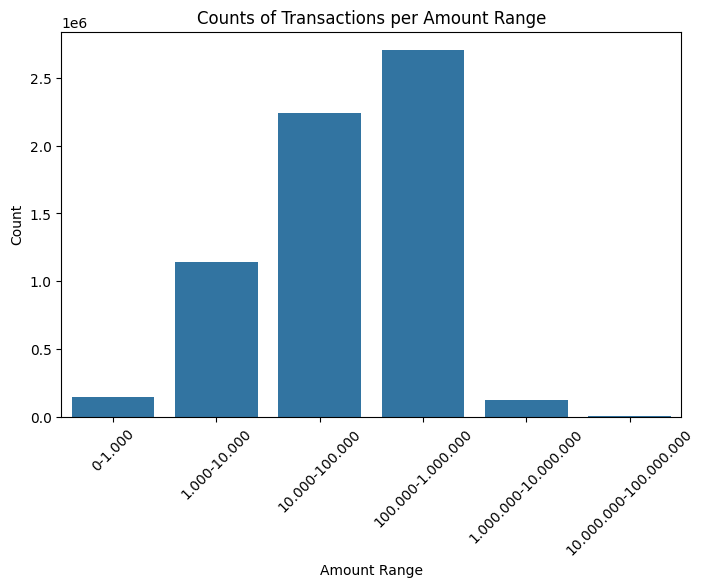

In [37]:
order = ['0-1.000', '1.000-10.000', '10.000-100.000', '100.000-1.000.000', '1.000.000-10.000.000', '10.000.000-100.000.000']


plt.figure(figsize=(8, 5))
barplot = sns.countplot(data=data, x='amount_range', order=order)

plt.title('Counts of Transactions per Amount Range')
plt.xlabel('Amount Range')
plt.ylabel('Count')

plt.xticks(rotation=45)  
plt.show()

Observations:

- The most commonn ranges are 10.000 - 100.000 and 100.000 - 1.000.000.
- The bins approach looks good to me even though other non exponential bin strategies could be considered. 
- I will study if this approach provides some insights about the relationship with fraudulent behaviours.

## oldbalanceOrig 

In [38]:
data['oldbalanceOrig'].describe()

count    6.362620e+06
mean     8.338831e+05
std      2.888243e+06
min      0.000000e+00
25%      0.000000e+00
50%      1.420800e+04
75%      1.073152e+05
max      5.958504e+07
Name: oldbalanceOrig, dtype: float64

Observations:

- The mean of the dataset is 833,883.1, which is significantly higher than the median of 14,208.0. This discrepancy suggests that the data is right-skewed, meaning there are a few very high values pulling the mean upwards. The spread of the data is considerable, as indicated by the standard deviation of 2,888,243, which measures the average distance of each data point from the mean. This high standard deviation indicates that the data points are spread out over a large range of values. 
- The range of the data is from 0 to 59,585,040, further emphasizing the significant variability within the dataset. The interquartile range (IQR), which is the range of the middle 50% of the data, is 107,315.2. This IQR shows that the middle half of the data is also spread out, though not as extensively as the entire range. Overall, the distribution of oldbalanceOrig is right-skewed with a few extremely high values contributing to a high mean and substantial spread in the dataset.

In [39]:
old_orig = data['oldbalanceOrig'].value_counts()
old_orig.head(10)

oldbalanceOrig
0.0      2102449
184.0        918
133.0        914
195.0        912
164.0        909
109.0        908
181.0        908
157.0        902
146.0        899
136.0        898
Name: count, dtype: int64

In [40]:
filtered_old_orig = old_orig[old_orig >1]

In [41]:
filtered_old_orig.head(90)

oldbalanceOrig
0.0      2102449
184.0        918
133.0        914
195.0        912
164.0        909
          ...   
122.0        823
158.0        822
105.0        821
119.0        821
168.0        820
Name: count, Length: 90, dtype: int64

In [42]:
integers = filtered_old_orig[filtered_old_orig.index % 1 == 0]
print(f'The length of the old balances with integers is: {len(integers)}')
integers.head(20)

The length of the old balances with integers is: 192885


oldbalanceOrig
0.0      2102449
184.0        918
133.0        914
195.0        912
164.0        909
109.0        908
181.0        908
157.0        902
146.0        899
136.0        898
128.0        898
169.0        896
115.0        896
147.0        891
162.0        886
186.0        885
165.0        884
104.0        883
153.0        880
100.0        880
Name: count, dtype: int64

In [43]:
non_integers = filtered_old_orig[filtered_old_orig.index % 1 != 0]
print(f'The length of the old balances with decimals is: {len(non_integers)}')
non_integers.head(20)

The length of the old balances with decimals is: 12395


oldbalanceOrig
429257.45     4
18392.51      4
1165187.89    4
18028.13      4
37906.33      4
51416.07      4
7921.41       3
89696.08      3
9622.70       3
42728.72      3
210691.92     3
44946.20      3
26894.85      3
34790.25      3
66066.73      3
32660.58      3
327707.29     3
59829.03      3
98089.42      3
34594.70      3
Name: count, dtype: int64

In [44]:
skewness_and_kurtosis(data,'newbalanceOrig')

{'skewness': 5.176882780698714, 'kurtosis': 32.06695841776864}

Observations:

- There are repeated old balances over time. I have divided them into amounts of integers and amounts with decimals.

- There are many transactions with old balance = 0€. How is this possible? We should compare the type of transaction to check what could have been happening. 

- Repeated old balances with integers are much more frequent than old balances with decimals. Is it a coincidence? 

- High skewness and kurtosis

## newbalanceOrig

In [45]:
data['newbalanceOrig'].describe()

count    6.362620e+06
mean     8.551137e+05
std      2.924049e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.442584e+05
max      4.958504e+07
Name: newbalanceOrig, dtype: float64

Observations:

- The mean is quite high (855,113.7), but the median is 0. This suggests that while the average balance is relatively high, a large proportion of records have a balance of 0. This indicates a right-skewed distribution with a significant number of zero or near-zero balances.

- The standard deviation is very high (2,924,049), indicating a high level of variability in the data. This large dispersion suggests that there are some very high balances compared to the majority. The range of 49,585,040 indicates that the balances vary widely, from 0 to nearly 50 million, highlighting the presence of extreme values. The quartiles further confirm that a large portion of the data has low balances (including zero), with a smaller proportion having higher balances.

In [46]:
new_orig = data['newbalanceOrig'].value_counts()
new_orig.head(10)

newbalanceOrig
0.00        3609566
26099.09          4
3684.32           4
18672.58          4
38767.21          4
7717.83           4
366.96            4
10528.49          4
8396.98           4
785.66            4
Name: count, dtype: int64

In [47]:
filtered_new_orig = new_orig[new_orig >1]
filtered_new_orig.head(10)

newbalanceOrig
0.00        3609566
26099.09          4
3684.32           4
18672.58          4
38767.21          4
7717.83           4
366.96            4
10528.49          4
8396.98           4
785.66            4
Name: count, dtype: int64

In [48]:
len(filtered_new_orig)

67497

In [49]:
integers = filtered_new_orig[filtered_new_orig.index % 1 == 0]
print(f'The length of the new balances with integers is: {len(integers)}')
integers.head()

The length of the new balances with integers is: 733


newbalanceOrig
0.0        3609566
5122.0           4
9192.0           3
33054.0          3
12323.0          3
Name: count, dtype: int64

In [50]:
non_integers = filtered_new_orig[filtered_new_orig.index % 1 != 0]
print(f'The length of the new balances with decimals is: {len(non_integers)}')
non_integers.head(20)

The length of the new balances with decimals is: 66764


newbalanceOrig
26099.09    4
3684.32     4
18672.58    4
38767.21    4
7717.83     4
366.96      4
10528.49    4
8396.98     4
785.66      4
4471.89     4
24038.92    4
4019.43     4
8555.34     4
7300.24     4
18392.51    4
9180.56     4
34203.45    4
37906.33    4
8864.63     4
5400.95     4
Name: count, dtype: int64

In [51]:
skewness_and_kurtosis(data,'newbalanceOrig')

{'skewness': 5.176882780698714, 'kurtosis': 32.06695841776864}

Observations:

- High skewness and kurtosis

## oldbalanceDest

In [52]:
data['oldbalanceDest'].describe()

count    6.362620e+06
mean     1.100702e+06
std      3.399180e+06
min      0.000000e+00
25%      0.000000e+00
50%      1.327057e+05
75%      9.430367e+05
max      3.560159e+08
Name: oldbalanceDest, dtype: float64

- The mean value of 1,100,702 is significantly higher than the median value of 132,705.7. This suggests that the distribution is positively skewed, meaning that there are some extremely high values (outliers) pulling the mean up.


- The standard deviation is very high (3,399,180), indicating a large variability around the mean. This is consistent with the large difference between the mean and median, as well as the large range. The range of 356,015,900 shows a wide spread between the minimum and maximum values.The fact that both the 25th percentile and the median are much lower than the 75th percentile and maximum reinforces the idea of a right-skewed distribution, with a large proportion of low to mid-range values and a few very high values.

In [53]:
old_dest = data['oldbalanceDest'].value_counts()
old_dest.head(20)

oldbalanceDest
0.0           2704388
10000000.0        615
20000000.0        219
30000000.0         86
40000000.0         31
102.0              21
198.0              19
125.0              18
160.0              18
132.0              18
214.0              17
156.0              17
106.0              17
194.0              16
164.0              16
190.0              16
184.0              16
144.0              16
168.0              16
173.0              16
Name: count, dtype: int64

In [54]:
filtered_old_dest = old_dest[old_dest >1]
filtered_old_dest.head()

oldbalanceDest
0.0           2704388
10000000.0        615
20000000.0        219
30000000.0         86
40000000.0         31
Name: count, dtype: int64

In [55]:
integers = filtered_old_dest[filtered_old_dest.index % 1 == 0]
print(f'The length of the old balances with integers is: {len(integers)}')
integers.head(20)

The length of the old balances with integers is: 9085


oldbalanceDest
0.0           2704388
10000000.0        615
20000000.0        219
30000000.0         86
40000000.0         31
102.0              21
198.0              19
125.0              18
160.0              18
132.0              18
214.0              17
156.0              17
106.0              17
194.0              16
164.0              16
190.0              16
184.0              16
144.0              16
168.0              16
173.0              16
Name: count, dtype: int64

In [56]:
non_integers = filtered_old_dest[filtered_old_dest.index % 1 != 0]
print(f'The length of the old balances with decimals is: {len(non_integers)}')
non_integers.head(20)

The length of the old balances with decimals is: 26972


oldbalanceDest
131876.43     3
257887.39     3
356501.32     3
300547.82     3
174807.40     3
205493.57     3
827259.33     3
53182.21      3
9721.05       3
1989.62       3
390984.82     3
274706.21     3
966592.66     3
436210.89     3
8607.54       3
171226.62     3
202009.46     3
102133.38     3
1470497.88    3
470498.90     3
Name: count, dtype: int64

In [57]:
skewness_and_kurtosis(data,'newbalanceOrig')

{'skewness': 5.176882780698714, 'kurtosis': 32.06695841776864}

Observations:

- High skewness and kurtosis

## newbalanceDest

In [58]:
data['newbalanceDest'].describe()

count    6.362620e+06
mean     1.224996e+06
std      3.674129e+06
min      0.000000e+00
25%      0.000000e+00
50%      2.146614e+05
75%      1.111909e+06
max      3.561793e+08
Name: newbalanceDest, dtype: float64

Observations:

- The mean and median values suggest a central tendency around a substantial amount. The mean (1,224,996) is higher than the median (214,661.4), indicating that while a substantial portion of the balances are around the median, the mean is significantly influenced by some very high balances. The large standard deviation (3,674,129) compared to the mean indicates high variability in the data. The spread of values is considerable, which is consistent with the maximum value being over 356 million.


- Both the 25th and 50th percentiles being at 0.0 and 214,661.4, respectively, highlight that while many entries are zero or low, there are also significant balances that push the mean higher. The 75th percentile value (1,111,909) shows that a substantial portion of the data has balances that are quite high compared to the median. The very high maximum value (356,179,300) indicates the presence of some extreme outliers. These extreme high values skew the mean upwards and contribute to the large standard deviation.

In [59]:
new_dest = data['newbalanceDest'].value_counts()
new_dest.head(10)

newbalanceDest
0.00           2439433
10000000.00         53
971418.91           32
19169204.93         29
16532032.16         25
1254956.07          25
1412484.09          22
1178808.14          21
7364724.84          21
4743010.67          21
Name: count, dtype: int64

In [60]:
filtered_new_dest = new_dest[new_dest >1]

In [61]:
integers = filtered_new_dest[filtered_new_dest.index % 1 == 0]
print(f'The length of the new balances with integers is: {len(integers)}')
integers.head(20)

The length of the new balances with integers is: 2907


newbalanceDest
0.0           2439433
10000000.0         53
12959765.0         13
1957240.0          10
3669753.0           9
5916456.0           9
2064290.0           9
1814949.0           9
1459243.0           9
1301547.0           8
3875177.0           8
843142.0            7
207790.0            7
10202533.0          7
1717034.0           7
5672225.0           7
5694992.0           7
7273180.0           7
13146711.0          7
3681137.0           7
Name: count, dtype: int64

In [62]:
non_integers = filtered_new_dest[filtered_new_dest.index % 1 != 0]
print(f'The length of the new balances with decimals is: {len(non_integers)}')
non_integers.head(20)

The length of the new balances with decimals is: 280856


newbalanceDest
971418.91      32
19169204.93    29
16532032.16    25
1254956.07     25
1412484.09     22
1178808.14     21
7364724.84     21
4743010.67     21
18123750.85    20
2107778.11     19
1517262.16     19
4619798.56     19
1186556.81     19
10388904.22    18
13033871.02    18
3940085.21     17
16408480.12    17
1015132.48     17
7984433.54     17
1371546.23     17
Name: count, dtype: int64

In [63]:
skewness_and_kurtosis(data,'newbalanceDest')

{'skewness': 19.35229749531714, 'kurtosis': 862.1558294704922}

Observations:

It catches my attention the amount of exact same amounts of money moved. Maybe it's a coincidence but needs further analysis.

- Very high skewness and kurtosis.

## Outliers

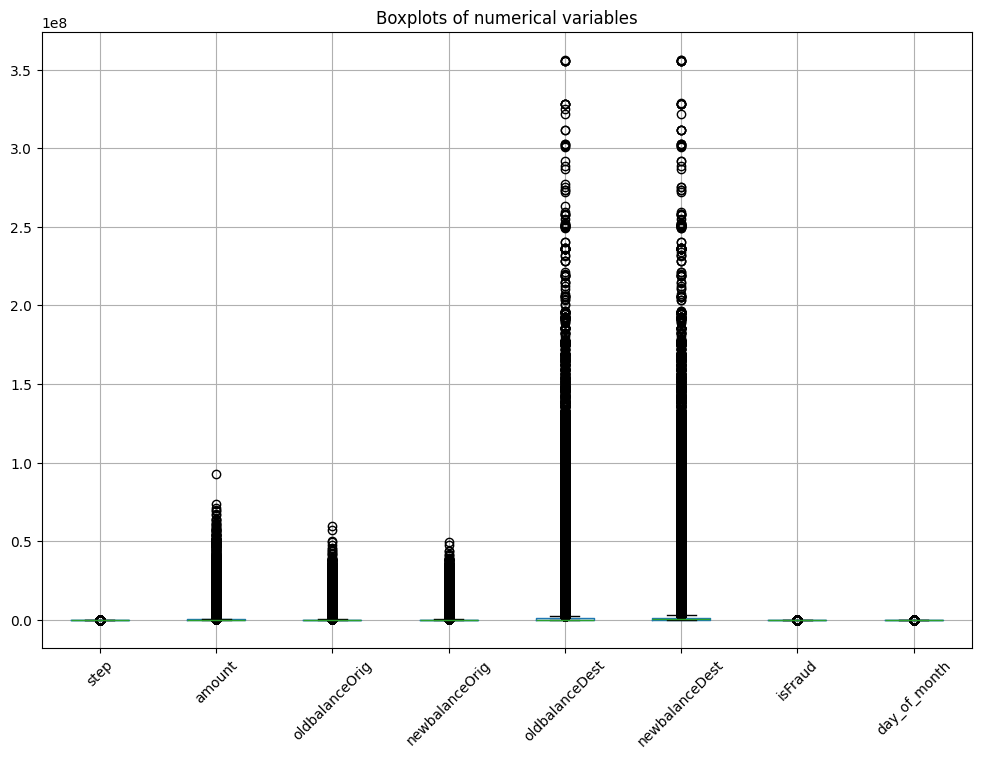

In [64]:
numeric_cols = data.select_dtypes(include=['int64','float64'])

plt.figure(figsize=(12, 8))
numeric_cols.boxplot()
plt.title('Boxplots of numerical variables')
plt.xticks(rotation=45)
plt.show()

In [65]:
detect_outliers(data)

Column: step, Percentage of outliers: 1.61%, Total number of outliers: 102688
Column: amount, Percentage of outliers: 5.31%, Total number of outliers: 338078
Column: oldbalanceOrig, Percentage of outliers: 17.49%, Total number of outliers: 1112507
Column: newbalanceOrig, Percentage of outliers: 16.56%, Total number of outliers: 1053391
Column: oldbalanceDest, Percentage of outliers: 12.36%, Total number of outliers: 786135
Column: newbalanceDest, Percentage of outliers: 11.61%, Total number of outliers: 738527
Column: day_of_month, Percentage of outliers: 2.54%, Total number of outliers: 161426
